In [329]:
import pandas as pd
import numpy as np
import scipy as sp
import random
import scipy.stats
import math
import statistics
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller

In [330]:
df = pd.read_csv(r"london_weather.csv")
df = df.drop(np.arange(3040,len(df)))
df = df[["date","mean_temp"]]
df = df.dropna()
df.insert(0,"index",np.arange(len(df)))
df = df.reset_index()
df.set_index("index")
df

,level_0,index,date,mean_temp
0,0,0,19790101,-4.1
1,1,1,19790102,-2.6
2,2,2,19790103,-2.8
3,3,3,19790104,-2.6
4,4,4,19790105,-0.8
...,...,...,...,...
3035,3035,3035,19870424,14.8
3036,3036,3036,19870425,15.0
3037,3037,3037,19870426,15.1
3038,3038,3038,19870427,15.6


In [331]:
t = df["index"]
temp = df["mean_temp"]

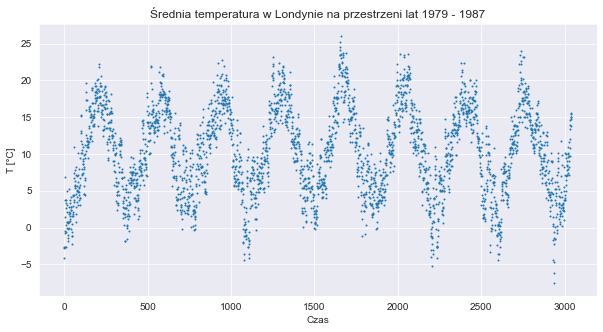

In [332]:
plt.figure(figsize = (10,5))
plt.scatter(t,temp,s=1)
plt.xlabel("Czas")
plt.ylabel("T [°C]")
plt.title("Średnia temperatura w Londynie na przestrzeni lat 1979 - 1987")

plt.savefig('obrazki/plot1.pdf', format='pdf')

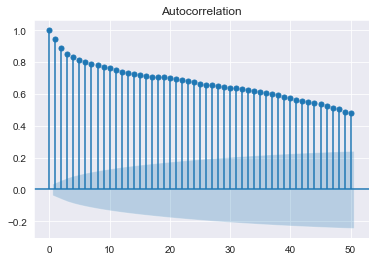

In [371]:
h = 50
plot_acf(temp, lags=h, adjusted=True)
plt.savefig('obrazki/acf1.pdf', format='pdf')

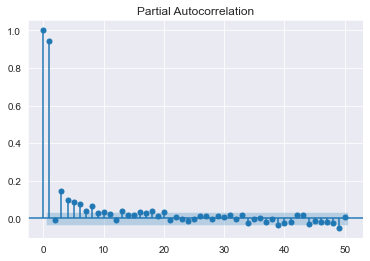

In [372]:
plot_pacf(temp, lags=h, method='ywm')
plt.savefig('obrazki/pacf1.pdf', format='pdf')

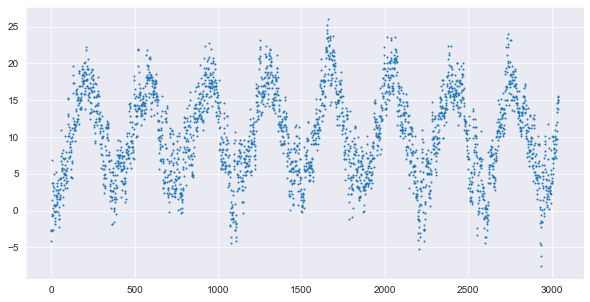

In [373]:
train = df
test = df.drop(train.index)
plt.figure(figsize = (10,5))
plt.scatter(train["index"],train["mean_temp"],s=1)

train_t = train["index"]
train_temp = train["mean_temp"]

In [374]:
#dekompozycja liniowości
a,b = np.linalg.lstsq(np.vstack([train_t, np.ones(len(train_t))]).T, train_temp, rcond=None)[0]

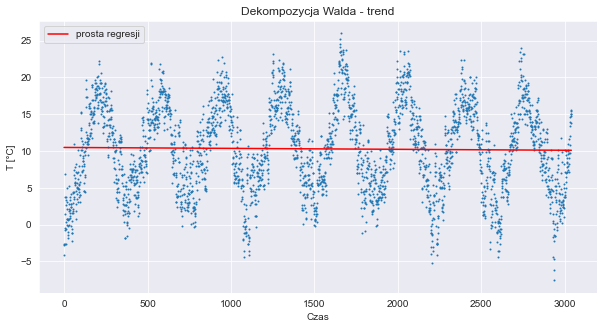

In [375]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp,s=1)
plt.plot(train_t,a*train_t+b,"r",label="prosta regresji")

plt.xlabel("Czas")
plt.ylabel("T [°C]")
plt.title("Dekompozycja Walda - trend")
plt.legend(loc="upper left")

plt.savefig('obrazki/plot2.pdf', format='pdf')

In [385]:
a, b

(-0.00012707255017574176, 10.486573582097298)

In [376]:
train_temp_2 = []
for i in range(len(train)):
    train_temp_2.append(train_temp[i] - a*train_t[i] - b)

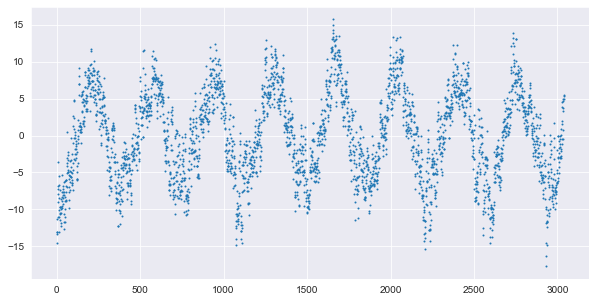

In [377]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp_2,s=1)

In [378]:
def func(t, c, d, e):
    return c* np.sin(d*t + e)

Q = np.quantile(train_temp_2, 0.9)
p0 = [Q,1/(350/1/(2*np.pi)),np.random.random()]
c_est, d_est, e_est = sp.optimize.curve_fit(func, xdata = train_t, ydata = train_temp_2,p0=p0,bounds = ((Q,0,0),(40,np.inf,10)))[0]

In [379]:
c_est, d_est, e_est

(7.6647057756085255, 0.017181405335791444, 4.307791989025751)

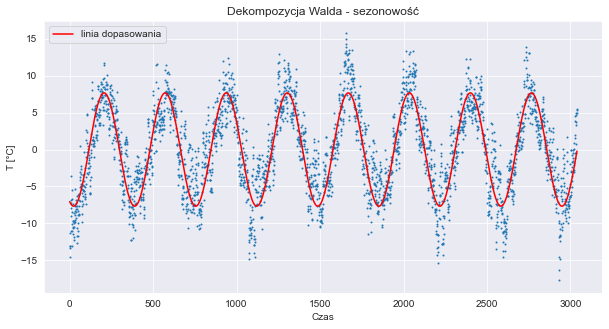

In [380]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp_2,s=1)
plt.plot(train_t,func(train_t,c_est, d_est, e_est),"r",label = "linia dopasowania")

plt.xlabel("Czas")
plt.ylabel("T [°C]")
plt.title("Dekompozycja Walda - sezonowość")
plt.legend(loc="upper left")

plt.savefig('obrazki/plot3.pdf', format='pdf')

In [381]:
train_temp_3 = []
for i in range(len(train)):
    train_temp_3.append(train_temp_2[i] - c_est* np.sin(d_est*train_t[i] + e_est))

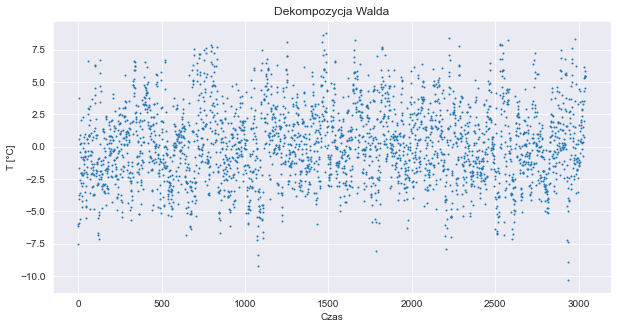

In [382]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp_3,s=1)
plt.xlabel("Czas")
plt.ylabel("T [°C]")
plt.title("Dekompozycja Walda")

plt.savefig('obrazki/plot4.pdf', format='pdf')

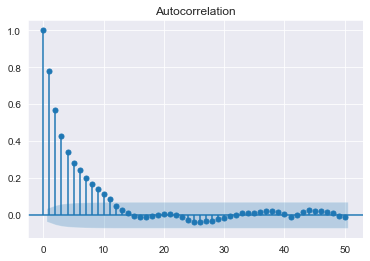

In [383]:
plot_acf(train_temp_3, lags=h, adjusted=True)
plt.savefig('obrazki/acf2.pdf', format='pdf')

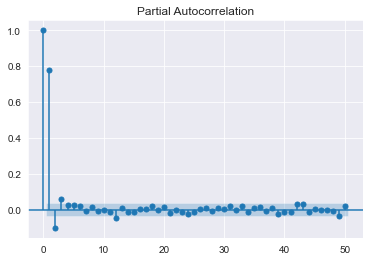

In [384]:
plot_pacf(train_temp_3, lags=h, method='ywm')
plt.savefig('obrazki/pacf2.pdf', format='pdf')

# Modelowanie danych przy pomocy ARMA

In [325]:
data = train_temp_3

df1 = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 20
max_q = 1

for p in range(0, max_p):
    print(p)
    for q in range(0, max_q):
        print(q)
        model = ARIMA(data, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df1['p']    = ps
df1['q']    = qs
df1['AIC']  = AIC
df1['BIC']  = BIC
df1['HQIC'] = HQIC

0
0
1
0
2
0
3
0
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0


In [326]:
df1.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
5,5,0,12400.829060,12442.966349,12415.975522
6,6,0,12401.210789,12449.367691,12418.521031
4,4,0,12401.332752,12437.450429,12414.315434
3,3,0,12401.401320,12431.499384,12412.220221
7,7,0,12402.935844,12457.112359,12422.409867


In [327]:
df1.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
3,3,0,12401.401320,12431.499384,12412.220221
2,2,0,12411.177539,12435.255990,12419.832660
4,4,0,12401.332752,12437.450429,12414.315434
5,5,0,12400.829060,12442.966349,12415.975522
6,6,0,12401.210789,12449.367691,12418.521031


In [328]:
df1.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
3,3,0,12401.401320,12431.499384,12412.220221
4,4,0,12401.332752,12437.450429,12414.315434
5,5,0,12400.829060,12442.966349,12415.975522
6,6,0,12401.210789,12449.367691,12418.521031
2,2,0,12411.177539,12435.255990,12419.832660


In [ ]:
p, q = 2, 2

model = ARIMA(train_temp_3, order=(p, 0, q)).fit()
#print(model.summary())

resid = model.resid
params = model.params